# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.svm import SVC
import cvxopt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.model_selection import train_test_split
# new installations
#pip install cvxopt

# Load Datasets

In [2]:
dataset_path = r"C:\Users\saura\OneDrive\Documents\IIT Hyderabad\Kernel Method_Sumohana\HW\HW1_dataset"
os.chdir(dataset_path)
os.listdir(dataset_path)

['Xsvm.csv', 'ysvm.csv']

In [3]:
df_x = pd.read_csv('Xsvm.csv', header = None)
print(df_x.shape)
df_x.head()

(500, 2)


,0,1
0,-1.022273,0.184018
1,1.126942,1.825408
2,1.121785,1.820051
3,-0.150259,1.665270
4,-1.068222,0.238349


In [4]:
df_y = pd.read_csv('ysvm.csv', header = None)
print(df_y.shape)
df_y.values[:10]

(500, 1)


array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.]])

In [5]:
#Initializing values and computing H. Note the 1. to force to float type
X = df_x.values
y = np.squeeze(df_y.values)

In [6]:
print(type(X))
print(type(y))
print(X.shape, y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(500, 2) (500,)


In [7]:
# ONLY IF WE ARE GENERATING THE DATASET YOURSELF

def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

# Q3 - SVM using Convex Optimization solvers

In [8]:
# common kernel functions
def linear(x, z):
    return np.dot(x, z.T)


def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p


def gaussian(x, z, sigma=0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

In [9]:
class SVM:
    def __init__(self, kernel=gaussian, C=1):
        """"""
        self.kernel = kernel
        self.C = C 

    def fit(self, X, y):
        """Fits the parameters via Convex Optimization - Quadratic Programming """
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        try : 
            sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        except : 
            sol = cvxopt.solvers.qp(P, q, G, h)
        self.alphas = np.array(sol["x"])

    def predict(self, X):
        """ Predicts the labels for the datapoints X """
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

<class 'numpy.ndarray'>
(500, 2) (500,)


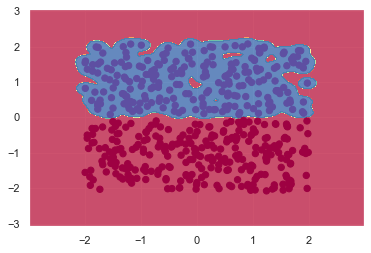

Accuracy: 1.0


In [10]:
if __name__ == "__main__":
    np.random.seed(1)
    #X, y = create_dataset(N=50)
    print(type(X))#numpy.ndarray
    print(X.shape, y.shape)
    #print(y)
    
    svm = SVM(kernel=gaussian)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    plot_contour(X, y, svm)

    print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

# Q4 Predict on Test Points

In [11]:
X_test =np.array([(1.9, 0.4), (0.9, 0.9),(1.4, 1.5), (0.01, 0.005)])
svm.predict(X_test)

array([1., 1., 1., 1.])

# Q5 - XOR 

### Generating XOR data  - Converting 0s to -1 s & Adding noise 

### NOTE - XOR function outputs either 1 or 0. Here , after generating the XOR truth table , we keeping the 1s in the Output y  as they were but the 0s are replaced by -1 

In [18]:
dict1 = {"Input1":[0,0,1,1], "Input2" :[0,1,0,1]}
df = pd.DataFrame(dict1)
df["Output"] = np.where(df["Input1"] == df["Input2"],-1,1) # XOR - 0 if both equal-- We denote it as -1 
df = pd.concat([df]*250, ignore_index=True)
noise1 = np.random.normal(0, .1, df.shape[0])
noise2 = np.random.normal(0, .1, df.shape[0])
df['Input1'] = df['Input1'] + noise1
df['Input2'] = df['Input2'] + noise2
print(df.shape)
df.head()

(1000, 3)


,Input1,Input2,Output
0,-0.013647,-0.070778,-1
1,0.053466,0.925561,1
2,1.010458,-0.047869,1
3,0.973930,1.026776,-1
4,-0.189543,0.063767,-1


### Prediction & Check Accuracy

In [19]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
svm = SVM(kernel=gaussian)
svm.fit(X, y)
xor_ypred = svm.predict(X)

print(f"Train Accuracy: {sum(y == xor_ypred)/X.shape[0]}")

Train Accuracy: 1.0
